In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data processing

We imagine we have the following folders and files, with the same naming conventions:

```bash
.
├── MATLAB
│   ├── README.md
│   ├── grain.m
│   ├── import_stl.mlx
│   ├── rev.m
├── REV1_600
│   ├── REV1_6003D_model
│   │   ├── Spec-1.STL
│   │   ├── Spec-2.STL
│   │   └── ...
│   ├── REV1_600Slices
│   │   ├── 1pics
│   │   │   ├── Spec-1_Imgs
│   │   │   │   ├── *.png
│   │   │   │   ├── *.png
│   │   │   │   └── ...
│   │   │   ├── Spec-2_Imgs
│   │   │   │   ├── *.png
│   │   │   │   ├── *.png
│   │   │   │   └── ...
│   │   │   ├── ...
│   │   ├── 3pics
│   │   └── ...
│   └── fabrics.txt
├── README.md
└── data_processing.ipynb <- YOU ARE CURRENTLY HERE
```

The idea is to construct a dataframe with every fabrics and only some sliced images (or all).

In [3]:
import numpy as numpy
import pandas as pd
from pathlib import Path
from pprint import pprint
from typing import List, Union, Optional, Callable
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms, utils
import torch.nn as nn
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import matplotlib
import torch.optim as optim
from tqdm import tqdm

seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

[INFO]: Computation device: cuda


## Construction of the dataframe

The dataframe is constructed as follow:

|  | id | orientation_0_std | ... | aspect_ratio_1_mean | aspect_ratio_1_std | size_mean | size_std | solidity_mean | solidity_std | roundness_mean | roundness_std | volume_fraction_mean | 6_images |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| 0 | Spec-1 | 0.324161 | ... | 0.7864 | 0.138574 | 0.104945 | 13.688080 | 4.475980 | 0.851367 | 0.097545 | 0.210755 | 0.086931 | [/home/matias/microstructure-reconstruction/MA... |
| 1 | Spec-2 | 0.373141 | ... | 0.847 | 0.138043 | 0.091564 | 6.019655 | 2.113804 | 0.965272 | 0.030363 | 0.297964 | 0.101607 | [/home/matias/microstructure-reconstruction/MA... |



In [4]:
# topLevelFolder = Path() / "REV1_600"
topLevelFolder = Path("drive/MyDrive/microstructure-reconstruction") / "REV1_600"
path_to_revs = topLevelFolder / "REV1_6003D_model"
path_to_fabrics =  topLevelFolder / "fabrics.txt"
path_to_slices = topLevelFolder / "REV1_600Slices"

In [5]:
nb_images = 3

fabrics_df = pd.read_csv(path_to_fabrics)
path_to_images = [x for x in path_to_slices.glob(f"{nb_images}p*/")]


def associate_rev_id_to_its_images(id: str, path_to_slices: Path, nb_images: int):
    """Associates a rev id, like `Spec-5` to its sliced images, given a number of slices per plane and

    Args:
        id (str): id of the rev id
        path_to_slices (Path): path to the slices images
        nb_images (int): number of slices per plane

    Returns:
        List[Path]: list of path where each path points an image
    """
    return [x for x in path_to_slices.glob(f"{nb_images}p*/{id}_Imgs/*")]


# We create a new column where each cell is a list of image paths
fabrics_df["photos"] = fabrics_df["id"].apply(
    func=associate_rev_id_to_its_images, args=(path_to_slices, nb_images)
)
fabrics_df = fabrics_df[fabrics_df.photos.str.len().gt(0)]
fabrics_df

,id,orientation-0_mean,orientation-0_std,orientation-1_mean,orientation-1_std,orientation-2_mean,orientation-2_std,orientation-3_mean,orientation-3_std,orientation-4_mean,orientation-4_std,orientation-5_mean,orientation-5_std,aspectratio-0_mean,aspectratio-0_std,aspectratio-1_mean,aspectratio-1_std,size_mean,size_std,solidity_mean,solidity_std,roundness_mean,roundness_std,volume_fraction,photos
1,Spec-1,0.324161,0.354717,0.321122,0.023721,0.022712,0.017081,0.307251,0.314178,0.307708,0.252944,0.241885,0.256148,0.693094,0.414169,0.138574,0.104945,13.688080,4.475980,0.851367,0.097545,0.210755,0.086931,0.386223,[drive/MyDrive/microstructure-reconstruction/R...
2,Spec-10,0.342926,0.329461,0.327613,0.003943,-0.008105,-0.007804,0.309317,0.301727,0.307888,0.250877,0.250333,0.258963,0.686181,0.404923,0.141167,0.097689,12.133247,3.346814,0.875065,0.051042,0.209093,0.082589,0.337122,[drive/MyDrive/microstructure-reconstruction/R...
3,Spec-100,0.343094,0.346566,0.310340,-0.000564,0.023228,-0.008377,0.316436,0.317267,0.300596,0.249503,0.247305,0.252536,0.685874,0.403992,0.140470,0.097848,13.673221,4.078330,0.865932,0.071402,0.208290,0.084531,0.339295,[drive/MyDrive/microstructure-reconstruction/R...
4,Spec-101,0.342479,0.330274,0.327246,-0.004556,-0.004594,0.001348,0.319543,0.311533,0.311565,0.249318,0.247188,0.249358,0.690586,0.413374,0.141739,0.104199,9.809217,2.654313,0.874050,0.054507,0.212802,0.090636,0.160133,[drive/MyDrive/microstructure-reconstruction/R...
5,Spec-102,0.331517,0.347090,0.321393,-0.003134,0.006752,-0.003562,0.311683,0.312832,0.300369,0.257236,0.248682,0.250519,0.692950,0.412637,0.137749,0.101959,11.310906,3.005233,0.875842,0.057680,0.215132,0.086989,0.278125,[drive/MyDrive/microstructure-reconstruction/R...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Spec-186,0.332370,0.320139,0.347491,-0.013794,-0.000316,-0.008002,0.308273,0.309078,0.313318,0.248679,0.258425,0.245474,0.688367,0.417648,0.136852,0.103046,8.743409,2.387816,0.876205,0.058424,0.212429,0.086477,0.106842,[drive/MyDrive/microstructure-reconstruction/R...
98,Spec-187,0.347766,0.329514,0.322721,0.004598,-0.004517,0.026167,0.308953,0.303466,0.301224,0.250498,0.255512,0.256184,0.684424,0.414719,0.142359,0.102347,8.887476,2.441451,0.874403,0.058699,0.209269,0.086716,0.103700,[drive/MyDrive/microstructure-reconstruction/R...
99,Spec-188,0.331884,0.318141,0.349975,-0.013346,-0.000843,0.007494,0.310789,0.308175,0.318548,0.247667,0.254386,0.246136,0.694662,0.411982,0.136650,0.100741,10.618896,2.911079,0.877366,0.052128,0.214151,0.085695,0.220278,[drive/MyDrive/microstructure-reconstruction/R...
100,Spec-189,0.338384,0.325607,0.336010,-0.004439,-0.009759,-0.008986,0.310169,0.309082,0.312984,0.246649,0.253739,0.251600,0.692863,0.413132,0.140263,0.104427,11.188183,3.004806,0.876578,0.052851,0.216790,0.088561,0.281035,[drive/MyDrive/microstructure-reconstruction/R...


## Simple CNN network

The original problem is:

    (P) Compute the fabrics from multiple sliced images per rev

We are firstly having an intermediate objective:

    (P') Compute the fabrics from one single sliced images per rev

Of course, the accuracy will be much worse because the fabrics are computed in every direction. However, it is a good try.

The first step is to transform the current dataframe where each row may represent multiple images into a dataframe where each row represent a single image

In [6]:
def convert_into_single_entry_df(multi_entry_df):
    nb_images = multi_entry_df.photos.str.len().max()
    assert nb_images == multi_entry_df.photos.str.len().min()
    single_entry_df = pd.concat([multi_entry_df] * nb_images, ignore_index=True)
    single_entry_df["photo"] = single_entry_df.apply(
                func=lambda row: str(row["photos"][row.name % nb_images]),
                axis=1,
            )
    single_entry_df.drop(columns="photos", inplace=True)
    return single_entry_df

single_entry_df = convert_into_single_entry_df(fabrics_df)
single_entry_df

,id,orientation-0_mean,orientation-0_std,orientation-1_mean,orientation-1_std,orientation-2_mean,orientation-2_std,orientation-3_mean,orientation-3_std,orientation-4_mean,orientation-4_std,orientation-5_mean,orientation-5_std,aspectratio-0_mean,aspectratio-0_std,aspectratio-1_mean,aspectratio-1_std,size_mean,size_std,solidity_mean,solidity_std,roundness_mean,roundness_std,volume_fraction,photo
0,Spec-1,0.324161,0.354717,0.321122,0.023721,0.022712,0.017081,0.307251,0.314178,0.307708,0.252944,0.241885,0.256148,0.693094,0.414169,0.138574,0.104945,13.688080,4.475980,0.851367,0.097545,0.210755,0.086931,0.386223,drive/MyDrive/microstructure-reconstruction/RE...
1,Spec-10,0.342926,0.329461,0.327613,0.003943,-0.008105,-0.007804,0.309317,0.301727,0.307888,0.250877,0.250333,0.258963,0.686181,0.404923,0.141167,0.097689,12.133247,3.346814,0.875065,0.051042,0.209093,0.082589,0.337122,drive/MyDrive/microstructure-reconstruction/RE...
2,Spec-100,0.343094,0.346566,0.310340,-0.000564,0.023228,-0.008377,0.316436,0.317267,0.300596,0.249503,0.247305,0.252536,0.685874,0.403992,0.140470,0.097848,13.673221,4.078330,0.865932,0.071402,0.208290,0.084531,0.339295,drive/MyDrive/microstructure-reconstruction/RE...
3,Spec-101,0.342479,0.330274,0.327246,-0.004556,-0.004594,0.001348,0.319543,0.311533,0.311565,0.249318,0.247188,0.249358,0.690586,0.413374,0.141739,0.104199,9.809217,2.654313,0.874050,0.054507,0.212802,0.090636,0.160133,drive/MyDrive/microstructure-reconstruction/RE...
4,Spec-102,0.331517,0.347090,0.321393,-0.003134,0.006752,-0.003562,0.311683,0.312832,0.300369,0.257236,0.248682,0.250519,0.692950,0.412637,0.137749,0.101959,11.310906,3.005233,0.875842,0.057680,0.215132,0.086989,0.278125,drive/MyDrive/microstructure-reconstruction/RE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,Spec-186,0.332370,0.320139,0.347491,-0.013794,-0.000316,-0.008002,0.308273,0.309078,0.313318,0.248679,0.258425,0.245474,0.688367,0.417648,0.136852,0.103046,8.743409,2.387816,0.876205,0.058424,0.212429,0.086477,0.106842,drive/MyDrive/microstructure-reconstruction/RE...
905,Spec-187,0.347766,0.329514,0.322721,0.004598,-0.004517,0.026167,0.308953,0.303466,0.301224,0.250498,0.255512,0.256184,0.684424,0.414719,0.142359,0.102347,8.887476,2.441451,0.874403,0.058699,0.209269,0.086716,0.103700,drive/MyDrive/microstructure-reconstruction/RE...
906,Spec-188,0.331884,0.318141,0.349975,-0.013346,-0.000843,0.007494,0.310789,0.308175,0.318548,0.247667,0.254386,0.246136,0.694662,0.411982,0.136650,0.100741,10.618896,2.911079,0.877366,0.052128,0.214151,0.085695,0.220278,drive/MyDrive/microstructure-reconstruction/RE...
907,Spec-189,0.338384,0.325607,0.336010,-0.004439,-0.009759,-0.008986,0.310169,0.309082,0.312984,0.246649,0.253739,0.251600,0.692863,0.413132,0.140263,0.104427,11.188183,3.004806,0.876578,0.052851,0.216790,0.088561,0.281035,drive/MyDrive/microstructure-reconstruction/RE...


In [15]:
class SinglePhotoDataset(Dataset):
    def __init__(self, df: pd.DataFrame, normalization: Union[bool, List[float]]= True, transform: transforms.Compose = transforms.Compose([transforms.ToTensor()])):
        df.reset_index(drop=True, inplace=True)
        df.drop(columns=["id"], inplace=True)

        self.images = df.pop("photo").to_numpy()
        self.labels = df.to_numpy()

        self._normalize(normalization)

        if not any([isinstance(tr, transforms.ToTensor) for tr in transform.transforms]):
            transform.transforms.append(transforms.ToTensor())

        self.transform = transform

    def _normalize(self, normalization):
        if isinstance(normalization, bool):
            if normalization:
                self.max = np.max(self.labels, axis=0)
                self.min = np.min(self.labels, axis=0)

                self.labels = (self.labels - self.min) / (self.max - self.min)

            else:
                self.max, self.min = None, None

        if isinstance(normalization, list):
            assert len(normalization) == 2
            assert all([isinstance(x, float) or isinstance(x, np.ndarray) for x in normalization])

            self.max = normalization[0]
            self.min = normalization[1]

            self.labels = (self.labels - self.min) / (self.max - self.min)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        if isinstance(idx, list):
            image = [Image.open(path) for path in img_path]
        else:
            image = Image.open(img_path).convert('RGB').convert('1')
            if self.transform:
                image = self.transform(image)

        label = torch.Tensor(self.labels[idx, :])
        return image, label

train_df, test_df = train_test_split(
    single_entry_df,
    train_size=0.8,
    random_state=seed,
    shuffle=True,
)
input_height = 64
transform = transforms.Compose([transforms.CenterCrop(207), transforms.Resize((input_height, input_height)), transforms.ToTensor(), transforms.GaussianBlur(kernel_size=3, sigma=0.5)])

train_dataset = SinglePhotoDataset(train_df, normalization=True, transform=transform)
validation_dataset = SinglePhotoDataset(test_df, normalization = [train_dataset.max, train_dataset.min], transform=transform)


In [77]:
class VGG11(nn.Module):
    def __init__(self, input_channel, input_height, output_size):
        super(VGG11, self).__init__()
        self.in_channels = input_channel
        self.output_size = output_size
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        input_fc = int((input_height / (2**4))**2 * 512)
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=input_fc, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=self.output_size)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

model = VGG11(input_channel=1, input_height = input_height, output_size=23).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

[INFO]: 54,361,879 total parameters.
[INFO]: 54,361,879 trainable parameters.


In [78]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=2)

validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2)
loss = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, 
                      weight_decay=0.0005)

torch.Size([23])


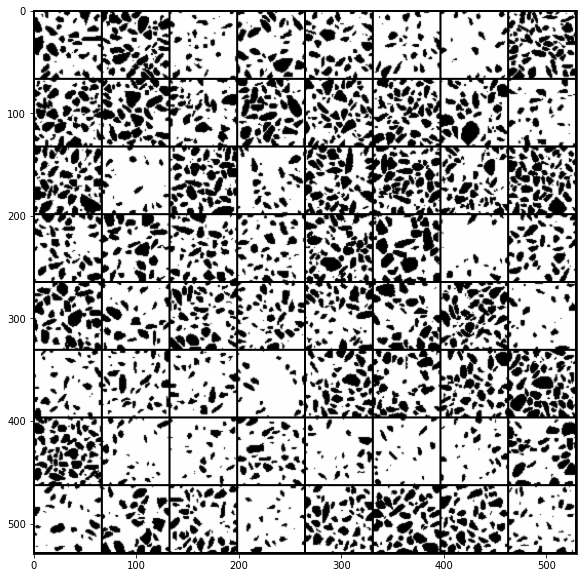

In [79]:
first_batch = next(train_dataloader._get_iterator())
images = first_batch[0]
labels = first_batch[1]
print(labels[0].shape)

labels = first_batch[1]
grid = utils.make_grid(images)

fig = plt.figure(figsize=(40, 10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()

In [ ]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('\nTraining')
    train_running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / counter
    return epoch_loss

def validate(model, testloader, criterion):
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    print('\nValidation')
    valid_running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
        
    epoch_loss = valid_running_loss / counter
    # print the accuracy for each class after evey epoch
    # the values should increase as the training goes on
    return epoch_loss

epochs = 100

# train_loss, validation_loss = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, train_dataloader, 
                                              optimizer, loss)
    validation_epoch_loss = validate(model, validation_dataloader,  
                                                 loss)
    train_loss.append(train_epoch_loss)
    validation_loss.append(validation_epoch_loss)
    print('\n')
    print(f"Training loss: {train_epoch_loss:.3f}.")
    print(f"Validation loss: {validation_epoch_loss:.3f}.")
    print('-'*50)

[INFO]: Epoch 1 of 100

Training


100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.94it/s]



Training loss: 0.148.
Validation loss: 0.146.
--------------------------------------------------
[INFO]: Epoch 2 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



Training loss: 0.148.
Validation loss: 0.145.
--------------------------------------------------
[INFO]: Epoch 3 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.97it/s]



Training loss: 0.148.
Validation loss: 0.145.
--------------------------------------------------
[INFO]: Epoch 4 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.97it/s]



Training loss: 0.148.
Validation loss: 0.145.
--------------------------------------------------
[INFO]: Epoch 5 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.97it/s]



Training loss: 0.147.
Validation loss: 0.147.
--------------------------------------------------
[INFO]: Epoch 6 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.89it/s]



Training loss: 0.148.
Validation loss: 0.145.
--------------------------------------------------
[INFO]: Epoch 7 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.99it/s]



Training loss: 0.147.
Validation loss: 0.147.
--------------------------------------------------
[INFO]: Epoch 8 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.89it/s]



Training loss: 0.148.
Validation loss: 0.146.
--------------------------------------------------
[INFO]: Epoch 9 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.148.
Validation loss: 0.145.
--------------------------------------------------
[INFO]: Epoch 10 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.148.
Validation loss: 0.145.
--------------------------------------------------
[INFO]: Epoch 11 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.96it/s]



Training loss: 0.147.
Validation loss: 0.145.
--------------------------------------------------
[INFO]: Epoch 12 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.97it/s]



Training loss: 0.147.
Validation loss: 0.145.
--------------------------------------------------
[INFO]: Epoch 13 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.98it/s]



Training loss: 0.147.
Validation loss: 0.145.
--------------------------------------------------
[INFO]: Epoch 14 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.148.
Validation loss: 0.144.
--------------------------------------------------
[INFO]: Epoch 15 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.147.
Validation loss: 0.144.
--------------------------------------------------
[INFO]: Epoch 16 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.146.
Validation loss: 0.146.
--------------------------------------------------
[INFO]: Epoch 17 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



Training loss: 0.147.
Validation loss: 0.144.
--------------------------------------------------
[INFO]: Epoch 18 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.147.
Validation loss: 0.144.
--------------------------------------------------
[INFO]: Epoch 19 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  2.00it/s]



Training loss: 0.146.
Validation loss: 0.144.
--------------------------------------------------
[INFO]: Epoch 20 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.147.
Validation loss: 0.145.
--------------------------------------------------
[INFO]: Epoch 21 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.146.
Validation loss: 0.144.
--------------------------------------------------
[INFO]: Epoch 22 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.146.
Validation loss: 0.144.
--------------------------------------------------
[INFO]: Epoch 23 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.86it/s]



Training loss: 0.146.
Validation loss: 0.144.
--------------------------------------------------
[INFO]: Epoch 24 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.146.
Validation loss: 0.143.
--------------------------------------------------
[INFO]: Epoch 25 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.86it/s]



Training loss: 0.146.
Validation loss: 0.143.
--------------------------------------------------
[INFO]: Epoch 26 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.96it/s]



Training loss: 0.146.
Validation loss: 0.143.
--------------------------------------------------
[INFO]: Epoch 27 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.146.
Validation loss: 0.143.
--------------------------------------------------
[INFO]: Epoch 28 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



Training loss: 0.146.
Validation loss: 0.143.
--------------------------------------------------
[INFO]: Epoch 29 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.88it/s]



Training loss: 0.146.
Validation loss: 0.145.
--------------------------------------------------
[INFO]: Epoch 30 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  2.01it/s]



Training loss: 0.146.
Validation loss: 0.143.
--------------------------------------------------
[INFO]: Epoch 31 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.87it/s]



Training loss: 0.145.
Validation loss: 0.143.
--------------------------------------------------
[INFO]: Epoch 32 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  2.00it/s]



Training loss: 0.146.
Validation loss: 0.142.
--------------------------------------------------
[INFO]: Epoch 33 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.89it/s]



Training loss: 0.146.
Validation loss: 0.143.
--------------------------------------------------
[INFO]: Epoch 34 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  2.01it/s]



Training loss: 0.145.
Validation loss: 0.142.
--------------------------------------------------
[INFO]: Epoch 35 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.91it/s]



Training loss: 0.145.
Validation loss: 0.143.
--------------------------------------------------
[INFO]: Epoch 36 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  2.02it/s]



Training loss: 0.145.
Validation loss: 0.142.
--------------------------------------------------
[INFO]: Epoch 37 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.145.
Validation loss: 0.142.
--------------------------------------------------
[INFO]: Epoch 38 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



Training loss: 0.146.
Validation loss: 0.144.
--------------------------------------------------
[INFO]: Epoch 39 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.88it/s]



Training loss: 0.144.
Validation loss: 0.142.
--------------------------------------------------
[INFO]: Epoch 40 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.145.
Validation loss: 0.142.
--------------------------------------------------
[INFO]: Epoch 41 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



Training loss: 0.144.
Validation loss: 0.142.
--------------------------------------------------
[INFO]: Epoch 42 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.97it/s]



Training loss: 0.145.
Validation loss: 0.141.
--------------------------------------------------
[INFO]: Epoch 43 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.91it/s]



Training loss: 0.144.
Validation loss: 0.141.
--------------------------------------------------
[INFO]: Epoch 44 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.96it/s]



Training loss: 0.144.
Validation loss: 0.144.
--------------------------------------------------
[INFO]: Epoch 45 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.145.
Validation loss: 0.141.
--------------------------------------------------
[INFO]: Epoch 46 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.96it/s]



Training loss: 0.145.
Validation loss: 0.142.
--------------------------------------------------
[INFO]: Epoch 47 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.89it/s]



Training loss: 0.144.
Validation loss: 0.142.
--------------------------------------------------
[INFO]: Epoch 48 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.89it/s]



Training loss: 0.144.
Validation loss: 0.141.
--------------------------------------------------
[INFO]: Epoch 49 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.91it/s]



Training loss: 0.144.
Validation loss: 0.143.
--------------------------------------------------
[INFO]: Epoch 50 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.144.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 51 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.91it/s]



Training loss: 0.144.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 52 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.144.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 53 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.143.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 54 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.99it/s]



Training loss: 0.142.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 55 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.94it/s]



Training loss: 0.143.
Validation loss: 0.142.
--------------------------------------------------
[INFO]: Epoch 56 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.98it/s]



Training loss: 0.144.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 57 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.142.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 58 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.142.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 59 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.88it/s]



Training loss: 0.142.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 60 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.89it/s]



Training loss: 0.142.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 61 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.91it/s]



Training loss: 0.142.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 62 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.97it/s]



Training loss: 0.143.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 63 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.90it/s]



Training loss: 0.142.
Validation loss: 0.142.
--------------------------------------------------
[INFO]: Epoch 64 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.94it/s]



Training loss: 0.143.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 65 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.89it/s]



Training loss: 0.143.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 66 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.143.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 67 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.89it/s]



Training loss: 0.142.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 68 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.96it/s]



Training loss: 0.141.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 69 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



Training loss: 0.141.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 70 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.97it/s]



Training loss: 0.141.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 71 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.141.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 72 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.88it/s]



Training loss: 0.143.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 73 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.90it/s]



Training loss: 0.140.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 74 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.94it/s]



Training loss: 0.141.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 75 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.142.
Validation loss: 0.138.
--------------------------------------------------
[INFO]: Epoch 76 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.91it/s]



Training loss: 0.143.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 77 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.94it/s]



Training loss: 0.142.
Validation loss: 0.141.
--------------------------------------------------
[INFO]: Epoch 78 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



Training loss: 0.142.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 79 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.91it/s]



Training loss: 0.142.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 80 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.141.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 81 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.89it/s]



Training loss: 0.141.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 82 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.88it/s]



Training loss: 0.142.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 83 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



Training loss: 0.141.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 84 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.90it/s]



Training loss: 0.141.
Validation loss: 0.138.
--------------------------------------------------
[INFO]: Epoch 85 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.141.
Validation loss: 0.141.
--------------------------------------------------
[INFO]: Epoch 86 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.142.
Validation loss: 0.138.
--------------------------------------------------
[INFO]: Epoch 87 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.142.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 88 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



Training loss: 0.142.
Validation loss: 0.138.
--------------------------------------------------
[INFO]: Epoch 89 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



Training loss: 0.141.
Validation loss: 0.138.
--------------------------------------------------
[INFO]: Epoch 90 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.91it/s]



Training loss: 0.141.
Validation loss: 0.138.
--------------------------------------------------
[INFO]: Epoch 91 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.140.
Validation loss: 0.138.
--------------------------------------------------
[INFO]: Epoch 92 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.89it/s]



Training loss: 0.140.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 93 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



Training loss: 0.141.
Validation loss: 0.138.
--------------------------------------------------
[INFO]: Epoch 94 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



Training loss: 0.140.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 95 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.98it/s]



Training loss: 0.141.
Validation loss: 0.138.
--------------------------------------------------
[INFO]: Epoch 96 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.86it/s]



Training loss: 0.141.
Validation loss: 0.138.
--------------------------------------------------
[INFO]: Epoch 97 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  2.00it/s]



Training loss: 0.141.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 98 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.90it/s]



Training loss: 0.142.
Validation loss: 0.139.
--------------------------------------------------
[INFO]: Epoch 99 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.95it/s]



Training loss: 0.141.
Validation loss: 0.140.
--------------------------------------------------
[INFO]: Epoch 100 of 100

Training



100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Validation



100%|██████████| 3/3 [00:01<00:00,  1.92it/s]



Training loss: 0.140.
Validation loss: 0.138.
--------------------------------------------------


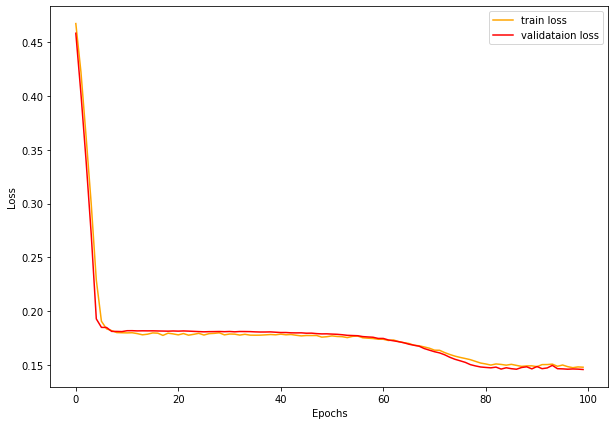

In [81]:
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss'
)
plt.plot(
    validation_loss, color='red', linestyle='-', 
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('loss_naive_network.png')
plt.show()

In [63]:
min = validation_dataset.min
max = validation_dataset.max

first_validation_batch = next(validation_dataloader._get_iterator())
image = first_validation_batch[0][0]
label = first_validation_batch[1][0]

prediction = model(torch.unsqueeze(image, 0).to(device))
unnormalized_prediction = prediction.cpu().detach().numpy() * (max - min) + min
unnormalized_label = label.cpu().detach().numpy() * (max - min) + min
gap = np.mean(np.absolute((unnormalized_prediction - unnormalized_label))/unnormalized_label)
gap*100

7.603600195105545